# Prepare Dataset

In [1]:
pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 614.1 kB/s eta 0:00:00


In [5]:
#Cleansing
import re
import pandas as pd
import numpy as np
import demoji
import pickle

#SKLearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

#defination of data test, train, and validation
df_train = pd.read_csv("/train_preprocess.tsv.txt", delimiter = "\t", header=None)
df_valid = pd.read_csv("/train_preprocess.tsv.txt", delimiter = "\t", header=None)
df_test = pd.read_csv("/train_preprocess.tsv.txt", delimiter = "\t", header=None)
df = df_train._append(df_valid, ignore_index=True)

df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

#ChangeAlayPath
df_kbbi = pd.read_csv('/KamusAlayIvan.csv', header=None, encoding='ISO-8859-1', names=['TIDAKBAKU', 'BAKU'])

import string

In [6]:
#DefinitionCleansingFunction
def removechars(text):
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))','',text)
    text = re.sub('\d', '', text)
    text = re.sub(r'\b\w\b', '', text)
###Stopwords in RemoveChars
    text = re.sub('di','',text)
    text = re.sub('yang','',text)
    text = re.sub('dan','',text)
    text = re.sub('nya','',text)
    text = re.sub('saya','',text)
    text = re.sub('ini','',text)
    text = re.sub('itu','',text)
    text = re.sub('aku','',text)
    text = re.sub('kamu','',text)
    text = re.sub('th','',text)
    return text

def changealay(text):
    alay = dict(zip(df_kbbi['TIDAKBAKU'], df_kbbi['BAKU']))
    text = ' '.join([alay[word] if word in alay else word for word in text.split(' ')])
    return text

In [7]:
def cleaning(text):
    text = removechars(text)
    text = changealay(text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

In [10]:
#DataSet
df = pd.read_csv("/train_preprocess.tsv.txt", delimiter = "\t", header=None)
df.columns =['text', 'label']
sentiment = ['negative', 'neutral', 'positive']

In [11]:
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


# Text Normalization/Cleansing


In [12]:
# Cek duplicate
df.duplicated().sum()

67

In [13]:
# Delete duplicate
df = df.drop_duplicates()

In [14]:
df.shape

(10933, 2)

In [15]:
df.label.value_counts()

label
positive    6383
negative    3412
neutral     1138
Name: count, dtype: int64

In [16]:
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10993,f - demokrat dorong upaya kemandirian energi n...,neutral
10994,tidak bosan,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


In [17]:
neg = df.loc[df['label'] == 'negative'].text.tolist()
neu = df.loc[df['label'] == 'neutral'].text.tolist()
pos = df.loc[df['label'] == 'positive'].text.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

In [18]:
total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print("Pos: %s, Neu: %s, Neg: %s" % (len(pos), len(neu), len(neg)))
print("Total data: %s" % len(total_data))

Pos: 6383, Neu: 1138, Neg: 3412
Total data: 10933


# Feature Extraction

In [19]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("tokenizer.pickle has created!")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("x_pad_sequences.pickle has created!")

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [20]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("y_labels.pickle has created!")

y_labels.pickle has created!


# **Prepare train & test datasets/Splitting Dataset**

In [21]:
from sklearn.model_selection import train_test_split

file = open("x_pad_sequences.pickle",'rb')
X = pickle.load(file)
file.close()

file = open("y_labels.pickle",'rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Train

In [22]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

In [23]:
embed_dim = 100
units = 64

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 10042435 (38.31 MB)
Trainable params: 10042435 (38.31 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
875/875 [==============================] - 39s 39ms/step - loss: 0.4667 - accuracy: 0.8171 - val_loss: 0.3429 - val_accuracy: 0.8797
Epoch 2/10
875/875 [==============================] - 10s 12ms/step - loss: 0.1983 - accuracy: 0.9273 - val_loss: 0.3565 - val_accuracy: 0.8834
Epoch 2: early stopping


# Evaluation


In [24]:
from sklearn import metrics

predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

69/69 [==============================] - 1s 4ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       668
           1       0.82      0.78      0.80       231
           2       0.93      0.92      0.93      1288

    accuracy                           0.88      2187
   macro avg       0.85      0.85      0.85      2187
weighted avg       0.88      0.88      0.88      2187



# Cross Validation


In [25]:
# Untuk lebih menyakinkan lagi, kita juga bisa melakukan "Cross Validation"
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100
units = 64

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]


    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
    model.add(LSTM(units, dropout=0.2))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=0)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0, callbacks=[es])

    predictions = model.predict(X_test)
    y_pred = predictions

    # for the current fold only
    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)

69/69 [==============================] - 1s 4ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       668
           1       0.78      0.83      0.80       231
           2       0.94      0.90      0.92      1288

    accuracy                           0.88      2187
   macro avg       0.84      0.86      0.85      2187
weighted avg       0.88      0.88      0.88      2187



69/69 [==============================] - 1s 3ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       668
           1       0.89      0.70      0.78       231
           2       0.92      0.92      0.92      1288

    accuracy                           0.89      2187
   macro avg       0.88      0.83      0.85      2187
weighted avg       0.89      0.89      0.88      2187



69/69 [==============================] - 1s 3ms/step
Training ke- 3
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       668
           1       0.92      0.75      0.82       231
           2       0.92      0.93      0.93      1288

    accuracy                           0.89      2187
   macro avg       0.89      0.85      0.86      2187
weighted avg       0.89      0.89      0.89      2187



69/69 [==============================] - 1s 4ms/step
Training ke- 4
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       668
           1       0.78      0.81      0.80       231
           2       0.93      0.88      0.90      1288

    accuracy                           0.86      2187
   macro avg       0.83      0.84      0.84      2187
weighted avg       0.87      0.86      0.86      2187



69/69 [==============================] - 1s 3ms/step
Training ke- 5
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       668
           1       0.85      0.72      0.78       231
           2       0.89      0.93      0.91      1288

    accuracy                           0.87      2187
   macro avg       0.86      0.82      0.83      2187
weighted avg       0.87      0.87      0.87      2187




Rata-rata Accuracy:  0.8760859625057156


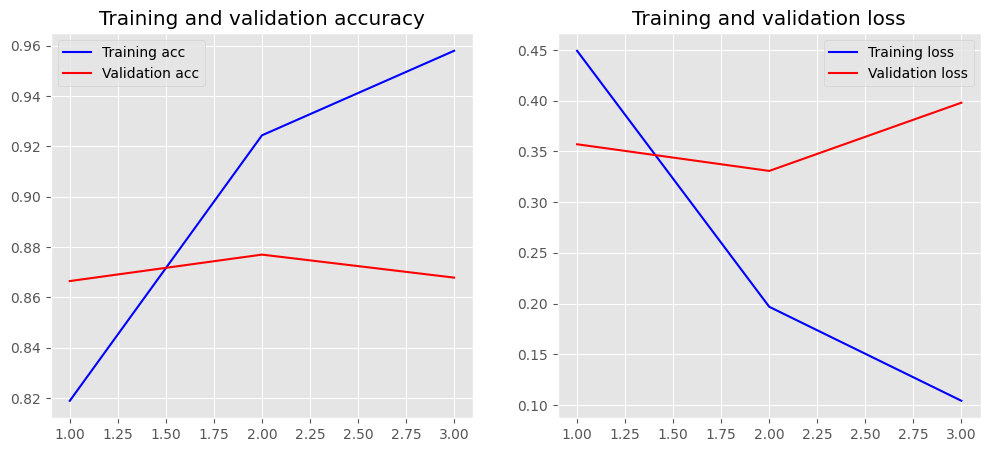

In [26]:
# history.history
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

%matplotlib inline
plot_history(history)

In [27]:
model.save('model.h5')
print("Model has created!")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model has created!


In [28]:
import re
from keras.models import load_model

input_text = """
bagus sekali.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 387ms/step
Text:   bagus sekali  
Sentiment:  positive


In [29]:
import re
from keras.models import load_model

input_text = """
jelek sekali.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 321ms/step
Text:   jelek sekali  
Sentiment:  negative


In [33]:
import re
from keras.models import load_model

input_text = """
hormati partai-partai yang telah berkoalisi	.
"""

def cleansing(sent):
    # Mengubah kata menjadi huruf kecil semua dengan menggunakan fungsi lower()
    string = sent.lower()
    # Menghapus emoticon dan tanda baca menggunakan "RegEx" dengan script di bawah
    string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
    return string

sentiment = ['negative', 'neutral', 'positive']

text = [cleansing(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ",text[0])
print("Sentiment: ",sentiment[polarity])

1/1 [==============================] - 0s 361ms/step
Text:   hormati partai partai yang telah berkoalisi   
Sentiment:  neutral
